In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from GPyOpt.methods import BayesianOptimization
import GPy
import GPyOpt
from numpy.random import seed
from tqdm import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# # define scikit-learn style colormap transform for RGBA outputs (label / discrete)
# helper code to map arbitrary class label nparray into rgb color that plato read
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn.apionly as sns
from sklearn import preprocessing

In [3]:

# # define scikit-learn style colormap transform for RGBA outputs (continous)
class RGBAContinuousTransformer():
    def __init__(self, colormap_type, resolution):
        self.colormap_type = colormap_type
        self.resolution = resolution
    
    def fit(self, data):
        self.max_ = np.max(data)
        self.min_ = np.min(data)
        self.range_ = self.max_ - self.min_
        self.seamap = sns.color_palette(self.colormap_type, n_colors=self.resolution)
        self.norm = mpl.colors.Normalize(vmin=self.min_, vmax=self.max_)
        self.colormap = cm.ScalarMappable(norm=self.norm, cmap=mpl.colors.ListedColormap(self.seamap))

    def transform(self, data):
        if len(data.shape) != 1 and not (1 in data.shape):
            raise Exception("1d array only is accepted")
        ret = self.colormap.to_rgba(data)
        ret = ret.reshape((len(data),4))
        return ret
        
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    def palplot(self):
        sample = np.arange(self.min_, self.max_, self.range_ / self.resolution)
        sns.palplot(self.transform(sample))
        print("Sample Min:" + str(self.min_) + ", Sample Max:" + str(self.max_) + ", Resolution:" + str(self.resolution))

In [14]:
from GPyOpt.objective_examples.experiments2d import function2d
import numpy as np
class SynthObj2d(function2d):
    '''
    Cosines function
    
    :param bounds: the box constraints to define the domain in which the function is optimized.
    :param sd: standard deviation, to generate noisy evaluations of the function.
    '''
    def __init__(self,bounds=None,sd=None):
        self.input_dim = 2
        if bounds == None: self.bounds = [(0,10),(0,10)]
        else: self.bounds = bounds
        self.min = [(0, 0)]
        self.fmin = 0
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.name = 'MyObj'

    def f(self,X):
#         X = reshape(X,self.input_dim)
        n = X.shape[0]
        if X.shape[1] != self.input_dim:
            return 'Wrong input dimension'
        else:
#             fval = -((2*X[:,1]**2+X[:,0]**2)>10**2)*2 - 1
#             fval = -((X[:,1]+X[:,0])>10)*2 - 1
            fval = -(np.sin(X[:,0]/3)>X[:,1]/10)*2 - 1
            if self.sd ==0:
                noise = np.zeros(n).reshape(n,1)
            else:
                noise = np.random.normal(0,self.sd,n).reshape(n,1)
            return -fval.reshape(n,1) + noise
        
    def boundary_plot(self, fig):
        x = np.linspace(0,10,100)
        y = 10 * np.sin(x/3)
        fig.add_subplot(2,2,1)
        plt.plot(x,y)
        plt.title('(a) Ground Truth Phase Boundary', loc='left')
        plt.xlim(0,10)
        plt.ylim(0,10)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.colorbar()
        
        

In [15]:
from itertools import product
from sklearn.neighbors import KNeighborsClassifier


def plot_contour(myProblem, obj, ite, colormap, precision=50, level=0):
    bounds = myProblem.space.get_bounds()
    gridx = np.linspace(bounds[0][0], bounds[0][1], precision)
    gridy = np.linspace(bounds[1][0], bounds[1][1], precision)
    
    xv, yv = np.meshgrid(gridx, gridy)
    zv = np.zeros((precision, precision))
    true_zv = np.zeros((precision, precision))
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(myProblem.X, myProblem.Y)
    
    for i in range(len(xv)):
        for j in range(len(xv)):
            zv[i,j] = myProblem.model.predict(np.array([xv[i,j],yv[i,j]]).T)[0]
#             zv[i,j] = knn.predict(np.array([xv[i,j],yv[i,j]]).reshape((1,-1)))[0]
            true_zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))
    plt.contour(xv, yv, zv,levels=[0], colors=colormap.transform(np.array([ite])))
    
    # round zv to int value
    zv = (zv>0) * 2 - 1
    return np.sum(zv!=true_zv) / precision**2

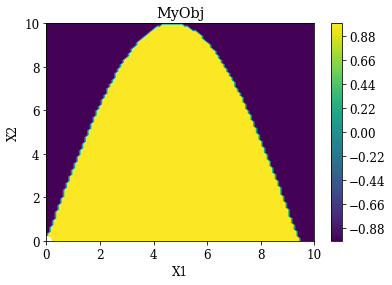

In [16]:
obj = SynthObj2d()
myf = obj.f
obj.plot()
# obj.boundary_plot()

In [7]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,10)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0,10)}]
max_iter = 10

In [ ]:
myProblem = BayesianOptimization(myf,bounds,acquisition_type="BinaryT",
                                 evaluator_type = 'local_penalization',
                                 batch_size = 5,
                                 num_cores = 1,)

In [ ]:
from IPython.display import clear_output

ITERATIONS = 9

cmap = RGBAContinuousTransformer('viridis', ITERATIONS)
cmap.fit(np.array([0, ITERATIONS]))
mis_classify_lst = []
for i in tqdm(range(ITERATIONS)):
    myProblem.run_optimization(max_iter=1) 
#     myProblem.plot_acquisition('{}.pdf'.format(i))
#     if i % 3 == 0:
#     mis_classify_lst.append(plot_contour(myProblem, obj, i, cmap, precision=40))


In [ ]:
import pandas as pd
pd.Series(mis_classify_lst).plot()

# no batch

In [20]:
myProblem = BayesianOptimization(myf,bounds,acquisition_type="BinaryT",
                                 evaluator_type = 'local_penalization',
                                 batch_size = 1,
                                 num_cores = 1,)


 74%|███████▍  | 149/200 [04:02<01:50,  2.17s/it]

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

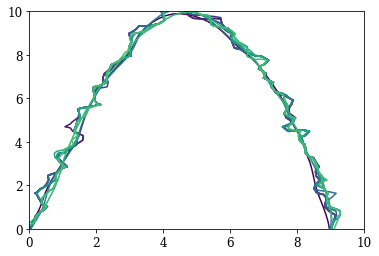

In [25]:
from IPython.display import clear_output

ITERATIONS = 200

cmap = RGBAContinuousTransformer('viridis', ITERATIONS)
cmap.fit(np.array([0, ITERATIONS]))
mis_classify_lst = []
for i in tqdm(range(ITERATIONS)):
    myProblem.run_optimization(max_iter=1) 
#     myProblem.plot_acquisition('{}.pdf'.format(i))
    if i % 10 == 0:
        mis_classify_lst.append(plot_contour(myProblem, obj, i, cmap, precision=50))

[[  6.5704418    9.43151272]
 [  5.68367383   3.26129337]
 [  5.78518553   1.59880768]
 [  4.8299098    6.26583377]
 [  5.68022346   0.14589912]
 [  1.13780214   8.73399108]
 [  7.99921706   6.28201907]
 [  2.7931219    7.15852244]
 [  8.84336985   2.01379273]
 [  6.65984116   4.84402527]
 [  3.97035285   8.55960411]
 [  0.07082374   4.91033484]
 [  1.01507719   0.43748682]
 [  2.4187381    4.43876379]
 [  6.05852994   6.61703189]
 [  1.35236873   3.61911636]
 [  2.57357631   8.35054348]
 [  5.2806769    8.72416023]
 [  7.51828468   0.39230823]
 [  5.1258887    9.98431776]
 [  8.80022791   0.29603429]
 [  7.37101991   1.84979768]
 [  0.24485234   3.31983364]
 [  8.68435143   1.22148113]
 [  8.22728279   4.03273917]
 [  6.65832325   7.09835589]
 [  7.04333501   5.27893694]
 [  1.28801047   4.25955066]
 [  5.810097     8.58739168]
 [  2.44014696   6.98306008]
 [  9.85472287   1.03902643]
 [  7.40912447   2.85390228]
 [  7.35327272   5.3237692 ]
 [  8.14541911   1.83781791]
 [  7.19915013

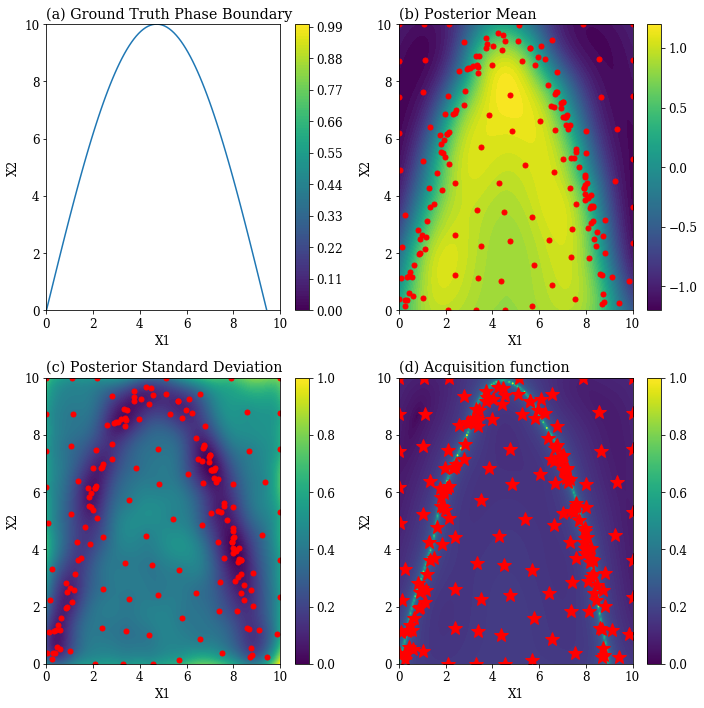

In [24]:
import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)


fig = myProblem.plot_acquisition_binaryT()
obj.boundary_plot(fig)
# plt.colorbar()
plt.tight_layout()
# plt.savefig('method_example.png', dpi=200)

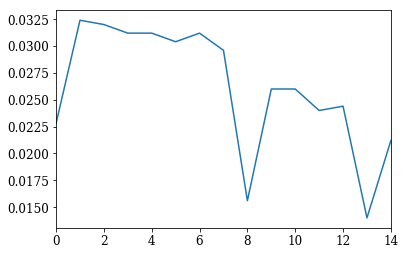

In [26]:
import pandas as pd
pd.Series(mis_classify_lst).plot()

# grid search

In [27]:
from sklearn.neighbors import KNeighborsClassifier

def grid_search(myProblem, obj, grid_precision, eval_precision = 50):
    bounds = myProblem.space.get_bounds()
    obsx = np.linspace(bounds[0][0], bounds[0][1], grid_precision)
    obsy = np.linspace(bounds[1][0], bounds[1][1], grid_precision)

    evalx = np.linspace(bounds[0][0], bounds[0][1], eval_precision)
    evaly = np.linspace(bounds[1][0], bounds[1][1], eval_precision)

    xv, yv = np.meshgrid(obsx, obsy)
    xv_eval, yv_eval = np.meshgrid(evalx, evaly)
    knn = KNeighborsClassifier(n_neighbors=1)
    zv = np.zeros((grid_precision, grid_precision))

    for i in range(len(obsx)):
        for j in range(len(obsx)):
            zv[i,j] = obj.f(np.array([[xv[i,j],yv[i,j]]]))

    knn.fit(np.vstack([xv.ravel(), yv.ravel()]).T, zv.ravel())
    true_zv = np.zeros((eval_precision, eval_precision))
    zv_eval = np.zeros((eval_precision, eval_precision))
    for i in range(len(xv_eval)):
        for j in range(len(xv_eval)):
            zv_eval[i,j] = knn.predict(np.array([xv_eval[i,j],yv_eval[i,j]]).reshape((1,-1)))[0]
            true_zv[i,j] = obj.f(np.array([[xv_eval[i,j],yv_eval[i,j]]]))

    plt.contour(xv, yv, zv,levels=[0])

    # round zv to int value
    zv_eval = (zv_eval>0) * 2 - 1

    num_data = grid_precision ** 2
    miss_rate = np.sum(zv_eval!=true_zv) / eval_precision**2
    return num_data, miss_rate


100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


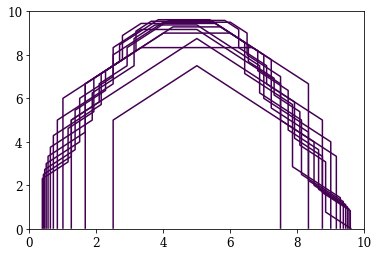

In [28]:
num_data_lst = []
miss_rate_lst = []
for i in tqdm(range(2,15)):
    num_data, miss_rate = grid_search(myProblem, obj, i)
    num_data_lst.append(num_data)
    miss_rate_lst.append(miss_rate)

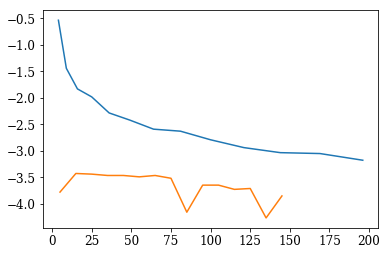

In [33]:
plot(num_data_lst, np.log(miss_rate_lst))
plot(range(5,5+len(mis_classify_lst)*10, 10), np.log(mis_classify_lst))

In [ ]:
# np.save('num_data_lst', np.array(num_data_lst),)
# np.save('miss_classify_grid', np.array(mis_classify_lst))
# np.save('miss_classify_active', np.array(miss_rate_lst))

In [ ]:
num_data_lst = np.load('num_data_lst.npy')
mis_classify_lst = np.load('miss_classify_grid.npy')
miss_rate_lst = np.load('miss_classify_active.npy')

In [ ]:
len(mis_classify_lst)

In [ ]:
import matplotlib 
matplotlib.rc('xtick', labelsize=12.5) 
matplotlib.rc('ytick', labelsize=12.5)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12.5}

matplotlib.rc('font', **font)

plot(num_data_lst, (miss_rate_lst))
plot(range(5,5+len(mis_classify_lst)), (mis_classify_lst))
plt.ylim(0,0.3)

plt.xticks([0,50,100,150,200])
plt.legend(['Grid Search', 'Active Learning (sequential)'])
plt.ylabel('Number of experiments')
plt.xlabel('Error rate')
plt.savefig('rate.pdf', dpi=300)

# add distance of points to the phase boundary